In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
import pandas as pd
import cv2
import os
import numpy as np
from numpy import genfromtxt

import tensorflow as tf
from fr_utils import *
from inception_blocks_v2 import *

import matplotlib.pyplot as plt # plt show pic
import matplotlib.image as mpimg # mpimg read pic

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(threshold=np.nan)#设置打印方式，设置打印输出数组的时候完全输出，不考虑中间数组数字用省略号代替

Using TensorFlow backend.


In [2]:
FRmodel = faceRecoModel(input_shape=(3, 96, 96))

In [3]:
print("Total Params:", FRmodel.count_params())

Total Params: 3743280


In [4]:
#to triplet_loss

def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    # Compute the (encoding) distance between the anchor and the positive, you will need to sum over axis=-1
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)),axis=-1)
    
    # Compute the (encoding) distance between the anchor and the negative, you will need to sum over axis=-1
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)),axis=-1)
    
    #  subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist,neg_dist),alpha)
    # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss,0))
    
    return loss

In [5]:
with tf.Session() as test:
    tf.set_random_seed(1)
    y_true = (None, None, None)
    y_pred = (tf.random_normal([3, 128], mean=6, stddev=0.1, seed = 1),
              tf.random_normal([3, 128], mean=1, stddev=1, seed = 1),
              tf.random_normal([3, 128], mean=3, stddev=4, seed = 1))
    loss = triplet_loss(y_true, y_pred)
    
    print("loss = " + str(loss.eval()))
    print(tf.random_normal([3, 128], mean=6, stddev=0.1, seed = 1).shape)

loss = 528.1432
(3, 128)


In [6]:
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])  #compile the model to configure the learning process
load_weights_from_FaceNet(FRmodel)

NameError: name 'triplet_loss' is not defined

In [8]:
X_train_orig, Y_train_orig, X_train_face, Y_train_face, X_test_orig, Y_test_orig, classes = load_dataset()

print ("X_train_orig shape: " + str(X_train_orig.shape))
print ("Y_train_orig shape: " + str(Y_train_orig.shape))
print ("X_train_face shape: " + str(X_train_face.shape))
print ("Y_train_face shape: " + str(Y_train_face.shape))
print ("X_test_orig shape: " + str(X_test_orig.shape))
print ("Y_test_orig shape: " + str(Y_test_orig.shape))
# print (X_train_face)
print (Y_train_face)
# # Normalize image vectorsload_dataset
# X_train = X_train_orig/255.
# X_test = X_test_orig/255.

# # Convert training and test labels to one hot matrices
# # Y_train = convert_to_one_hot(Y_train_orig, 2).T
# # Y_test = convert_to_one_hot(Y_test_orig, 2).T

# print (Y_train_orig)
# print (Y_train_orig.shape)
# print ("classes = " + str(classes.shape))
# print ("number of training examples = " + str(X_train.shape))
# print ("number of test examples = " + str(X_test.shape))
# print ("X_train shape: " + str(X_train.shape))
# print ("Y_train shape: " + str(Y_train.shape))
# print ("X_test shape: " + str(X_test.shape))
# print ("Y_test shape: " + str(Y_test.shape))

X_train_orig shape: (600, 64, 64, 3)
Y_train_orig shape: (1, 600)
X_train_face shape: (426, 96, 96, 3)
Y_train_face shape: (426,)
X_test_orig shape: (150, 64, 64, 3)
Y_test_orig shape: (1, 150)
[b'younes' b'bertrand' b'sebastiano' b'felix' b'younes' b'dan' b'bertrand'
 b'felix' b'sebastiano' b'benoit' b'felix' b'felix' b'kian' b'dan'
 b'felix' b'dan' b'kian' b'younes' b'sebastiano' b'younes' b'arnaud'
 b'younes' b'arnaud' b'felix' b'benoit' b'younes' b'bertrand' b'dan'
 b'bertrand' b'younes' b'felix' b'kian' b'kian' b'benoit' b'bertrand'
 b'younes' b'younes' b'dan' b'kian' b'sebastiano' b'younes' b'felix'
 b'arnaud' b'sebastiano' b'felix' b'younes' b'benoit' b'kian' b'younes'
 b'felix' b'felix' b'sebastiano' b'dan' b'bertrand' b'benoit' b'felix'
 b'felix' b'bertrand' b'benoit' b'kian' b'kian' b'dan' b'bertrand'
 b'younes' b'sebastiano' b'bertrand' b'bertrand' b'bertrand' b'felix'
 b'dan' b'dan' b'dan' b'felix' b'sebastiano' b'younes' b'sebastiano'
 b'felix' b'felix' b'younes' b'bertran

In [30]:
FRmodel.fit(X_train, Y_train, epochs = 2, batch_size = 1)

ValueError: Error when checking input: expected input_2 to have shape (3, 96, 96) but got array with shape (64, 64, 3)

In [23]:
database = {}

database["jiapeng"] = img_to_encoding("images/jiapeng.jpg", FRmodel)
database["hummels"] = img_to_encoding("images/hummels0001.jpg", FRmodel)

#print(img_to_encoding("images/hummels0001.jpg", FRmodel))
print(database["hummels"])
print(database["jiapeng"])
print(database["hummels"].shape)
print(database["jiapeng"].shape)

[[ 0.02810847  0.19964851 -0.02111732  0.04075492  0.00516438  0.21340764
   0.03810462 -0.12894668 -0.19270866  0.01364904 -0.03765793 -0.00161802
   0.0488648  -0.08918736  0.04684208 -0.06211025 -0.01159386  0.03262144
   0.03156286  0.08837752 -0.05763199  0.01369522 -0.01633122  0.06406984
  -0.04727435 -0.01040259 -0.17810307 -0.13391465  0.04867166  0.08305226
  -0.02273735  0.14790823 -0.07695935  0.02783689  0.08597673  0.05214426
   0.07974438  0.01099573  0.01483155 -0.02968717  0.07952277 -0.1177639
   0.03320864 -0.08476486 -0.12525095  0.15554424  0.22704554  0.02634209
  -0.25039437  0.02949528  0.03208448  0.01969469  0.08702829  0.02417147
   0.06909872  0.0257948   0.03837335  0.03261432  0.03182554 -0.08275095
  -0.08418452  0.1874277   0.09361799 -0.2320033   0.09637288  0.0749924
   0.08540724 -0.08888578 -0.18638805  0.00348136 -0.02142136  0.00302292
  -0.04028639  0.11307624  0.11902692  0.05207444 -0.06161294 -0.0123931
   0.08501741  0.02319297  0.00550559  0.

In [25]:
# zu verify

def verify(image_path, identity, database, model):
    """
    Function that verifies if the person on the "image_path" image is "identity".
    
    Arguments:
    image_path -- path to an image
    identity -- string, name of the person you'd like to verify the identity. Has to be a resident of the Happy house.
    database -- python dictionary mapping names of allowed people's names (strings) to their encodings (vectors).
    model -- your Inception model instance in Keras
    
    Returns:
    dist -- distance between the image_path and the image of "identity" in the database.
    door_open -- True, if the door should open. False otherwise.
    """
    
    
    # Compute the encoding for the image. Use img_to_encoding() see example above. 
    encoding = img_to_encoding(image_path, model)
    
    # Compute distance with identity's image (≈ 1 line)
    dist = np.linalg.norm(encoding-database[identity])
    
    # Open the door if dist < Schwellwert(0.5), else don't open 
    if dist<0.7:
        print("It's " + str(identity) + ", welcome home!")
        door_open = True
    else:
        print("It's not " + str(identity) + ", please go away")
        door_open = False
        
        
    return dist, door_open

It's jiapeng, welcome home!


(0.30667, True)

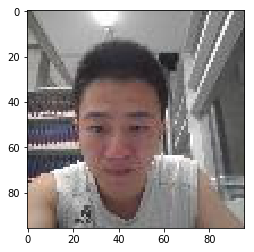

In [63]:
plt.imshow(mpimg.imread('images/jiapeng1.jpg') )
verify("images/jiapeng1.jpg", "jiapeng", database, FRmodel)



It's jiapeng, welcome home!


(0.34204462, True)

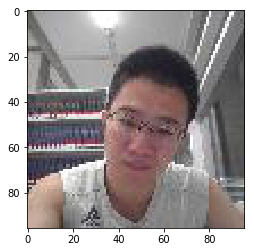

In [64]:
plt.imshow(mpimg.imread('images/jiapeng2.jpg') )
verify("images/jiapeng2.jpg", "jiapeng", database, FRmodel)

It's jiapeng, welcome home!


(0.28999534, True)

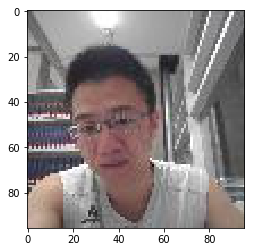

In [65]:
plt.imshow(mpimg.imread('images/jiapeng3.jpg') )
verify("images/jiapeng3.jpg", "jiapeng", database, FRmodel)

It's jiapeng, welcome home!


(0.41608486, True)

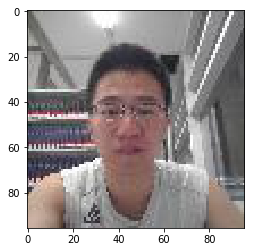

In [66]:
plt.imshow(mpimg.imread('images/jiapeng4.jpg') )
verify("images/jiapeng4.jpg", "jiapeng", database, FRmodel)

In [67]:
##plt.imshow(mpimg.imread('images/jiapeng5.jpg') )
##verify("images/jiapeng5.jpg", "jiapeng", database, FRmodel)

It's hummels, welcome home!


(0.0, True)

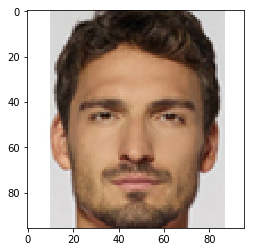

In [74]:
plt.imshow(mpimg.imread('images/hummels0001.jpg') )
verify("images/hummels0001.jpg", "hummels", database, FRmodel)

It's hummels, welcome home!


(0.696632, True)

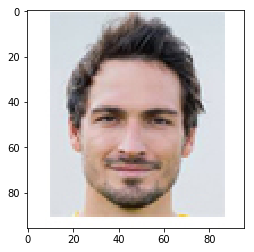

In [68]:
plt.imshow(mpimg.imread('images/hummels0002.jpg') )
verify("images/hummels0002.jpg", "hummels", database, FRmodel)

It's hummels, welcome home!


(0.49952433, True)

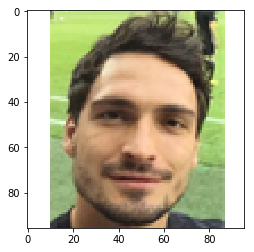

In [69]:
plt.imshow(mpimg.imread('images/hummels0003.jpg') )
verify("images/hummels0003.jpg", "hummels", database, FRmodel)

It's not hummels, please go away


(0.8659559, False)

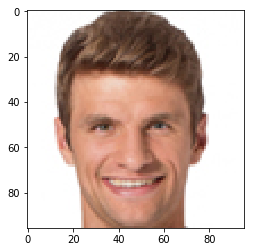

In [80]:
plt.imshow(mpimg.imread('images/muller0001.jpg') )
verify("images/muller0001.jpg", "hummels", database, FRmodel)

It's not hummels, please go away


(0.9621849, False)

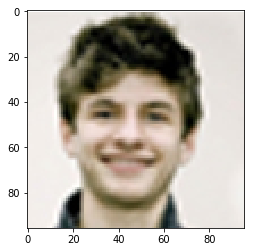

In [81]:
plt.imshow(mpimg.imread('images/muller0002.jpg') )
verify("images/muller0002.jpg", "hummels", database, FRmodel)

It's not hummels, please go away


(0.78154033, False)

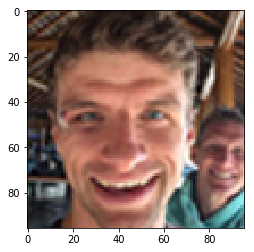

In [82]:
plt.imshow(mpimg.imread('images/muller0003.jpg') )
verify("images/muller0003.jpg", "hummels", database, FRmodel)

It's not hummels, please go away


(0.89298654, False)

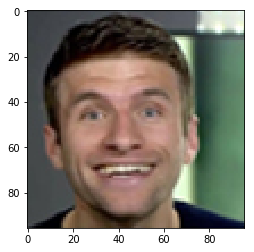

In [83]:
plt.imshow(mpimg.imread('images/muller0004.jpg') )
verify("images/muller0004.jpg", "hummels", database, FRmodel)

In [93]:
#  Face Recognition: who_is_it
#Compute the target encoding of the image from image_path
#find the encoding from the database that has smallest distance with the target encoding.
#Initialize the min_dist variable to a large enough number (100). It will help you keep track of what is the closest encoding to the input's encoding.
#loop over the database dictionary's names and encodings. To loop use for (name, db_enc) in database.items().
#compute L2 distance between the target "encoding" and the current "encoding" from the database.
#If this distance is less than the min_dist, then set min_dist to dist, and identity to name.

def who_is_it(image_path, database, model):
    """
    Implements face recognition for the happy house by finding who is the person on the image_path image.
    
    Arguments:
    image_path -- path to an image
    database -- database containing image encodings along with the name of the person on the image
    model -- your Inception model instance in Keras
    
    Returns:
    min_dist -- the minimum distance between image_path encoding and the encodings from the database
    identity -- string, the name prediction for the person on image_path
    """
    
    
    ##Compute the target "encoding" for the image. Use img_to_encoding() see example above. ## 
    encoding = img_to_encoding(image_path, model)
    
    ##Find the closest encoding ##
    
    # Initialize "min_dist" to a large value, make it 100 maybe? 
    min_dist = 100
    
    # Loop over the database dictionary's names and encodings.
    for (name, db_enc) in database.items():
        
        # Compute L2 distance between the target "encoding" and the current "emb" from the database. 
        dist = np.linalg.norm(encoding-database[name])

        # If this distance is less than the min_dist, then set min_dist to dist, and identity to name. 
        if dist<min_dist:
            min_dist = dist
            identity = name


    #Schwellwert(0.5)
    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    return min_dist, identity

it's jiapeng, the distance is 0.30667


(0.30667, 'jiapeng')

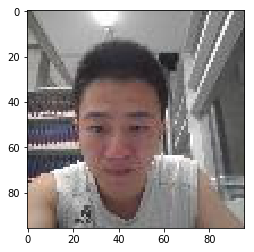

In [94]:
plt.imshow(mpimg.imread('images/jiapeng1.jpg') )
who_is_it("images/jiapeng1.jpg", database, FRmodel)

it's jiapeng, the distance is 0.34204462


(0.34204462, 'jiapeng')

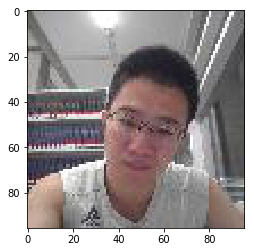

In [95]:
plt.imshow(mpimg.imread('images/jiapeng2.jpg') )
who_is_it("images/jiapeng2.jpg", database, FRmodel)

it's jiapeng, the distance is 0.28999534


(0.28999534, 'jiapeng')

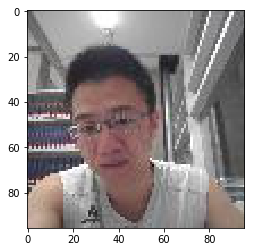

In [96]:
plt.imshow(mpimg.imread('images/jiapeng3.jpg') )
who_is_it("images/jiapeng3.jpg", database, FRmodel)

it's jiapeng, the distance is 0.41608486


(0.41608486, 'jiapeng')

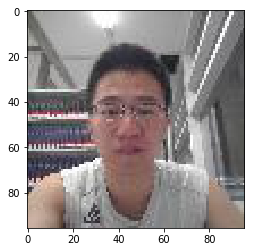

In [97]:
plt.imshow(mpimg.imread('images/jiapeng4.jpg') )
who_is_it("images/jiapeng4.jpg", database, FRmodel)

it's jiapeng, the distance is 0.65037227


(0.65037227, 'jiapeng')

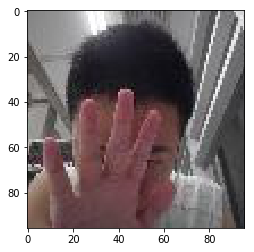

In [98]:
plt.imshow(mpimg.imread('images/jiapeng5.jpg') )
who_is_it("images/jiapeng5.jpg", database, FRmodel)

it's hummels, the distance is 0.0


(0.0, 'hummels')

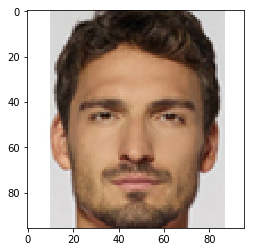

In [99]:
plt.imshow(mpimg.imread('images/hummels0001.jpg') )
who_is_it("images/hummels0001.jpg", database, FRmodel)

it's hummels, the distance is 0.696632


(0.696632, 'hummels')

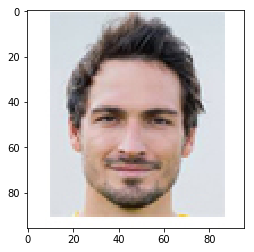

In [100]:
plt.imshow(mpimg.imread('images/hummels0002.jpg') )
who_is_it("images/hummels0002.jpg", database, FRmodel)

Not in the database.


(0.83538014, 'jiapeng')

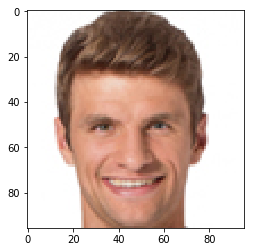

In [101]:
plt.imshow(mpimg.imread('images/muller0001.jpg') )
who_is_it("images/muller0001.jpg", database, FRmodel)

it's hummels, the distance is 0.49952433


(0.49952433, 'hummels')

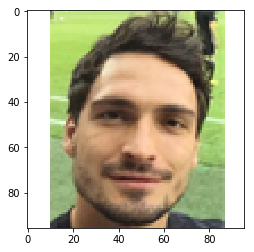

In [102]:
plt.imshow(mpimg.imread('images/hummels0003.jpg') )
who_is_it("images/hummels0003.jpg", database, FRmodel)

In [11]:
# train_dataset = h5py.File('datasets/train_happy.h5', "r")

f = h5py.File('datasets/train_face.h5', "r") #打开h5文件
# 可以查看所有的主键
for key in f.keys():
    print(f[key].name)
#     print(f[key].shape)
#     print(f[key].value)


/list_classes
/train_set_x
/train_set_y
